We test whether TDE can enhace prediction abilities of ESNs applied to the Lorenz System.

In [1]:
cd("$(homedir())/Documents/Repos/enso_project.jl")
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\lisah\Documents\Repos\enso_project.jl`


In [2]:
using ReservoirComputing, CSV, DataFrames, DynamicalSystems, Plots, enso_project

┌ Warning: Package cuDNN not found in current path.
│ - Run `import Pkg; Pkg.add("cuDNN")` to install the cuDNN package, then restart julia.
│ - If cuDNN is not installed, some Flux functionalities will not be available when running on the GPU.
└ @ FluxCUDAExt C:\Users\lisah\.julia\packages\Flux\9PibT\ext\FluxCUDAExt\FluxCUDAExt.jl:10


## Simulating Lorenz Data

In [3]:
# Set up the Lorenz system and generate data
lorenz = Systems.lorenz63()

# Integrate the system
T = 200.0
Δt = 0.1
Ttr = 100.0  # Transient that will be discarded

tr = trajectory(lorenz, T, Δt = Δt, Ttr = Ttr)
x, y, z = columns(tr[1])

# Put the data in the matrix format (n_features, n_samples) required by ReservoirComputing.jl 
data = copy(hcat(x, y, z)')

3×2001 Matrix{Float64}:
  -7.9554  -15.3466  -13.1091  -3.50536  …   2.60804   4.85809   9.20262
 -14.5316  -21.0154   -3.5192   3.71577      4.24185   7.98143  14.6799
  12.6248   30.0779   41.0784  30.7804      17.4522   15.3366   18.8447

In [4]:
l_max = lyapunov(lorenz, 100, Ttr = 100)

0.8986638632954478

In [5]:
# make data stochastic
var = 4
data_rand = data + var * randn(size(data)) 

3×2001 Matrix{Float64}:
 -11.9332  -12.6158  -13.9373   -0.430569  …   0.608557  12.76      6.23667
 -19.4104  -21.5299   -2.66409   5.45828      -0.657311   3.38873  19.7468
  17.542    27.5022   43.5503   32.1145       16.4399    10.5688   23.3302

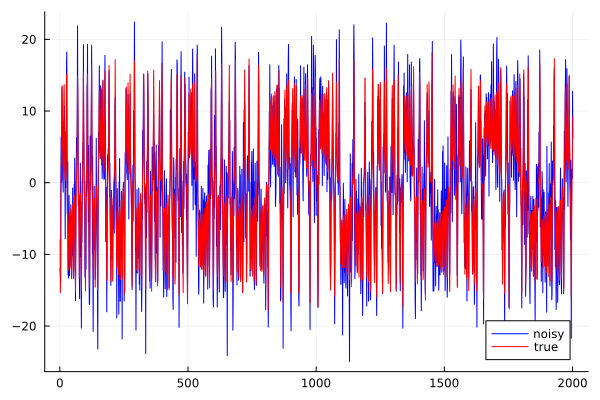

In [6]:
# visually check stochasticity
plot(data_rand[1, :], color="blue", label = "noisy")
plot!(data[1,:], color = "red", label ="true")

## Tools

In [7]:
"""
    train_val_test_split(data; val_seconds, test_seconds, Δt = 0.1)

Split the given data into training, validation, and test sets.
"""
function train_val_test_split(data, N_train, N_val)
    
    ind = N_train + N_val
    
    train_data = data[:, 1:N_train]
    val_data = data[:, N_train+1:ind]
    test_data = data[:, ind+1:end]
    
    return train_data, val_data, test_data
end

train_val_test_split

In [8]:
"""
    plot_prediction_tde_sep(esn_x, esn_y, esn_z, W_x, W_y, W_z, test_data_x,test_data_y,test_data_z, λ_max, title)

plot predictions versus the given test set, when TDE is performed seperately on different observables
"""
function plot_prediction_sep(esn_x, esn_y, esn_z, W_x, W_y, W_z, test_data_x,test_data_y,test_data_z, λ_max, title)
    
    prediction_x = esn_x(Generative(size(test_data_x, 2)), W_x)
    prediction_y = esn_y(Generative(size(test_data_y, 2)), W_y)
    prediction_z = esn_z(Generative(size(test_data_z, 2)), W_z)
    
    label = ["actual" "predicted"]
    times_x = Δt * collect(0:size(test_data_x, 2))[1:end-1] / λ_max
    times_y = Δt * collect(0:size(test_data_y, 2))[1:end-1] / λ_max
    times_z = Δt * collect(0:size(test_data_z, 2))[1:end-1] / λ_max

    print(test_data_z[1,:])

    p1 = plot(times_x, [test_data_x[1, :], prediction_x[1, :]], label = label, ylabel = "x(t)")
    p2 = plot(times_y, [test_data_y[1, :], prediction_y[1, :]], label = label, ylabel = "y(t)")
    p3 = plot(times_z, [test_data_z[1, :], prediction_z[1, :]], label = label, ylabel = "z(t)", xlabel = "t * λ_max")
    plot(p1, p2, p3, layout = (3, 1), size = (800, 600), title=title)
end

plot_prediction_sep

In [9]:
"""
    plot_comparison(esn_1d, esn_tde, W_1d, W_tde, test_data, λ_max, title)

"""
function plot_comparison(esn_1d, esn_tde, W_1d, W_tde, test_data, λ_max, title)

    prediction_size = size(test_data, 2)
    
    prediction_1d = esn_1d(Generative(prediction_size), W_1d)
    prediction_tde = esn_1d(Generative(prediction_size), W_tde)
    
    label = ["actual" "predicted"]
    times = Δt * collect(0:steps_to_predict)[1:end-1] / λ_max

    p2 = plot(times, [test_data[1, :], prediction_1d[1, :]], label = label, ylabel = "")
    p3 = plot(times, [test_data[1, :], prediction_tde[1, :]], label = label, ylabel = "", xlabel = "t * λ_max")
    plot(p2, p3, layout = (2, 1), size = (800, 600), title=title)
end

plot_comparison

In [10]:
"""
    plot_prediction(esn, Wₒᵤₜ, test_data, λ_max)

Given an Echo State Network, plot its predictions versus the given test set.
"""
function plot_prediction(esn, Wₒᵤₜ, test_data, λ_max, title)
    steps_to_predict = size(test_data, 2)
    prediction = esn(Generative(steps_to_predict), Wₒᵤₜ)
    
    label = ["actual" "predicted"]
    times = Δt * collect(0:steps_to_predict)[1:end-1] / λ_max

    p1 = plot(times, [test_data[1, :], prediction[1, :]], label = label, ylabel = "x(t)")
    p2 = plot(times, [test_data[2, :], prediction[2, :]], label = label, ylabel = "y(t)")
    p3 = plot(times, [test_data[3, :], prediction[3, :]], label = label, ylabel = "z(t)", xlabel = "t * λ_max")
    plot(p1, p2, p3, layout = (3, 1), size = (800, 600), title=title)
end

plot_prediction

## TDE on each observable seperately

we perform a TDE of a 1D observation of the Lorenz System

In [11]:
# use random data 
data = data_rand

3×2001 Matrix{Float64}:
 -11.9332  -12.6158  -13.9373   -0.430569  …   0.608557  12.76      6.23667
 -19.4104  -21.5299   -2.66409   5.45828      -0.657311   3.38873  19.7468
  17.542    27.5022   43.5503   32.1145       16.4399    10.5688   23.3302

In [13]:
# perform TDE on x_data 
x_data_emb, τ = enso_project.tde_with_negative_shift(data[1,:])
y_data_emb, τ = enso_project.tde_with_negative_shift(data[2,:])
z_data_emb, τ = enso_project.tde_with_negative_shift(data[3,:])

Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.
Stochastic signal, valid embedding NOT achieved ⨉.
Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.
Stochastic signal, valid embedding NOT achieved ⨉.
Algorithm stopped due to convergence of E₁-statistic. Valid embedding achieved ✓.


([31.822870476373065 39.23145863097071 … 43.55030170033135 17.542006294264716; 24.09525643861483 38.42509730624498 … 32.114472601175834 27.502152357250502; … ; 10.568766416763644 23.28301657727469 … 18.08529249688106 18.32040746696446; 23.33015161237819 16.439940768605425 … 13.652575555737675 19.111320389841694], 2)

In [20]:
n = minimum([size(x_data_emb,1), size(y_data_emb,1),size(z_data_emb,1)])
x_data_emb = x_data_emb[1:n,:]
y_data_emb = y_data_emb[1:n,:]
z_data_emb = z_data_emb[1:n,:];

In [21]:
N_train = floor(Int, n * 0.8)
N_val = floor(Int, (n-N_train) /2)
N_test = n - N_train - N_val

197

In [22]:
train_x_data_emb, val_x_data_emb, test_x_data_emb = train_val_test_split(Matrix(x_data_emb)', N_train, N_val)
train_y_data_emb, val_y_data_emb, test_y_data_emb = train_val_test_split(Matrix(y_data_emb)', N_train, N_val)
train_z_data_emb, val_z_data_emb, test_z_data_emb = train_val_test_split(Matrix(z_data_emb)', N_train, N_val)


([31.822870476373065 24.09525643861483 … 32.42682109978989 29.565226231244512; 39.23145863097071 38.42509730624498 … 16.37293245203976 29.35491957166813; … ; 43.55030170033135 32.114472601175834 … 21.640730653400773 41.7372134056288; 17.542006294264716 27.502152357250502 … 12.971749951899016 8.406013461642726], [23.99879276693063 18.398262060622468 … 12.077519708168545 24.910659213066772; 32.42682109978989 29.565226231244512 … 24.716520737992457 17.90376675212869; … ; 43.92793963454676 20.814944923752343 … 25.096825456401586 25.32687398824825; 21.640730653400773 41.7372134056288 … 29.396271098621256 26.518434693138325], [27.39616306286973 40.81566073565806 … 24.965451618162387 22.495085828898638; 12.077519708168545 24.910659213066772 … 30.39767778995375 32.781080225914884; … ; 21.09072285323571 23.680444287545203 … 47.640907066761486 25.718033353028584; 25.096825456401586 25.32687398824825 … 14.099635200644254 31.48127947936132])

In [23]:
spectral_radii = [0.8, 0.9, 1.0, 1.2]
sparsities = [0.03, 0.05, 0.14, 0.1]
input_scales = [0.1, 0.5, 1.0, 2.0]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [450, 470, 490, 1000]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

esn_x_emb, W_out_x_emb, val_loss_x_emb = enso_project.cross_validate_esn(train_x_data_emb, val_x_data_emb, param_grid)

enso_project.ESNHyperparams(450, 0.8, 0.03, 0.1, 0.0)
Validation loss = 216942.14367250213
enso_project.ESNHyperparams(470, 0.8, 0.03, 0.1, 0.0)
Validation loss = 166637.01571735716
enso_project.ESNHyperparams(470, 0.9, 0.03, 0.1, 0.0)
Validation loss = 151916.08046210717
enso_project.ESNHyperparams(490, 0.8, 0.05, 0.1, 0.0)
Validation loss = 122792.807575833
enso_project.ESNHyperparams(490, 0.8, 0.1, 0.1, 0.0)
Validation loss = 116196.17215268168
enso_project.ESNHyperparams(490, 0.8, 0.1, 0.1, 1.0e-6)
Validation loss = 115646.343378721
enso_project.ESNHyperparams(490, 0.8, 0.1, 0.1, 1.0e-5)
Validation loss = 114559.0363169187


(ESN(7 => 490), OutputLayer successfully trained with output size: 7, 114559.0363169187)

In [24]:
spectral_radii = [0.8, 0.9, 1.0, 1.2]
sparsities = [0.03, 0.05, 0.14, 0.1]
input_scales = [0.1, 0.5, 1.0, 2.0]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [600, 650, 700, 750, 800]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

esn_y_emb, W_out_y_emb, val_loss_y_emb = enso_project.cross_validate_esn(train_y_data_emb, val_y_data_emb, param_grid)

enso_project.ESNHyperparams(600, 0.8, 0.03, 0.1, 0.0)
Validation loss = 209879.11959617506
enso_project.ESNHyperparams(650, 0.8, 0.03, 0.1, 0.0)
Validation loss = 203109.67798354878
enso_project.ESNHyperparams(600, 0.9, 0.03, 0.1, 0.0)
Validation loss = 197112.9353303659
enso_project.ESNHyperparams(650, 1.0, 0.03, 0.1, 0.0)
Validation loss = 184139.1222590853
enso_project.ESNHyperparams(700, 1.2, 0.03, 0.1, 0.0)
Validation loss = 177686.7735563304
enso_project.ESNHyperparams(600, 1.0, 0.05, 0.1, 0.0)
Validation loss = 173532.10027131566
enso_project.ESNHyperparams(600, 0.9, 0.03, 0.1, 1.0e-5)
Validation loss = 172858.34261577105
enso_project.ESNHyperparams(600, 1.2, 0.05, 0.1, 1.0e-5)
Validation loss = 172211.35786058195


(ESN(7 => 600), OutputLayer successfully trained with output size: 7, 172211.35786058195)

In [25]:
spectral_radii = [0.9]
sparsities = [0.05, 0.14]
input_scales = [0.1, 0.5, 1.0, 2.0]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [560, 600]

param_grid = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

esn_z_emb, W_out_z_emb, val_loss_z_emb = enso_project.cross_validate_esn(train_z_data_emb, val_z_data_emb, param_grid)

enso_project.ESNHyperparams(560, 0.9, 0.05, 0.1, 0.0)
Validation loss = 200045.25591077082
enso_project.ESNHyperparams(560, 0.9, 0.14, 0.1, 0.0)
Validation loss = 186851.06933071802
enso_project.ESNHyperparams(560, 0.9, 0.14, 0.1, 1.0e-6)
Validation loss = 125103.42020235487
enso_project.ESNHyperparams(560, 0.9, 0.05, 1.0, 1.0e-6)
Validation loss = 121263.42280314685
enso_project.ESNHyperparams(560, 0.9, 0.14, 1.0, 1.0e-6)
Validation loss = 108327.95189290971
enso_project.ESNHyperparams(560, 0.9, 0.14, 2.0, 1.0e-6)
Validation loss = 102462.93492991121
enso_project.ESNHyperparams(560, 0.9, 0.05, 2.0, 1.0e-5)
Validation loss = 96032.58245403992


(ESN(6 => 560), OutputLayer successfully trained with output size: 6, 96032.58245403992)

## ESN training without TDE

In [26]:
data = data[:,1:n]

x_data_1d = Matrix(data[1,:]')
y_data_1d = Matrix(data[2,:]')
z_data_1d = Matrix(data[3,:]')


train_data_x_1D, val_data_x_1D, test_data_x_1D = train_val_test_split(x_data_1d, N_train, N_val)
train_data_y_1D, val_data_y_1D, test_data_y_1D = train_val_test_split(y_data_1d, N_train, N_val)
train_data_z_1D, val_data_z_1D, test_data_z_1D = train_val_test_split(z_data_1d, N_train, N_val)

([17.542006294264716 27.502152357250502 … 12.971749951899016 8.406013461642726], [21.640730653400773 41.7372134056288 … 29.396271098621256 26.518434693138325], [25.096825456401586 25.32687398824825 … 14.099635200644254 31.48127947936132])

In [27]:
spectral_radii = [0.8, 1.0, 1.2]
sparsities = [0.03, 0.05]
input_scales = [0.1, 0.5]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [512, 1024]

param_grid_x = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

In [28]:
# network training
esn_x_1D, W_out_x_1D, val_loss_x_1D = enso_project.cross_validate_esn(train_data_x_1D, val_data_x_1D, param_grid_x)

enso_project.ESNHyperparams(512, 0.8, 0.03, 0.1, 0.0)
Validation loss = 18871.748191574236
enso_project.ESNHyperparams(512, 0.8, 0.03, 0.1, 1.0e-6)
Validation loss = 18772.238366247744
enso_project.ESNHyperparams(512, 1.2, 0.03, 0.1, 1.0e-5)
Validation loss = 18391.791111397175


(ESN(1 => 512), OutputLayer successfully trained with output size: 1, 18391.791111397175)

In [29]:
spectral_radii = [0.8, 1.0, 1.2]
sparsities = [0.03, 0.05]
input_scales = [0.1, 0.5]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [512, 1024]

param_grid_y = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

In [30]:
esn_y_1D, W_out_y_1D, val_loss_y_1D = enso_project.cross_validate_esn(train_data_y_1D, val_data_y_1D, param_grid_y)

enso_project.ESNHyperparams(512, 0.8, 0.03, 0.1, 0.0)
Validation loss = 40662.167606330826
enso_project.ESNHyperparams(512, 1.2, 0.03, 0.1, 0.0)
Validation loss = 34454.988670012026
enso_project.ESNHyperparams(512, 0.8, 0.05, 0.1, 0.0)
Validation loss = 32704.05666979811
enso_project.ESNHyperparams(512, 1.2, 0.05, 0.1, 0.0)
Validation loss = 28489.83985831478
enso_project.ESNHyperparams(512, 1.2, 0.03, 0.5, 0.0)
Validation loss = 25360.441989732437
enso_project.ESNHyperparams(512, 0.8, 0.05, 0.5, 1.0e-5)
Validation loss = 25331.36884788557


(ESN(1 => 512), OutputLayer successfully trained with output size: 1, 25331.36884788557)

In [31]:
spectral_radii = [0.8, 1.0, 1.2]
sparsities = [0.03, 0.05]
input_scales = [0.1, 0.5]
ridge_values = [0.0, 1e-6, 1e-5]
reservoir_sizes = [512, 1024]

param_grid_z = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values);

In [32]:
esn_z_1D, W_out_z_1D, val_loss_z_1D = enso_project.cross_validate_esn(train_data_z_1D, val_data_z_1D, param_grid_z)

enso_project.ESNHyperparams(512, 0.8, 0.03, 0.1, 0.0)
Validation loss = 5.379974539096362e9
enso_project.ESNHyperparams(512, 1.0, 0.03, 0.1, 0.0)
Validation loss = 3.764287865850492e7
enso_project.ESNHyperparams(512, 1.2, 0.03, 0.1, 0.0)
Validation loss = 34852.3119378274
enso_project.ESNHyperparams(512, 1.0, 0.05, 0.1, 0.0)
Validation loss = 27400.081014035262
enso_project.ESNHyperparams(512, 0.8, 0.03, 0.5, 1.0e-6)
Validation loss = 19224.75937224666
enso_project.ESNHyperparams(1024, 0.8, 0.03, 0.5, 1.0e-6)
Validation loss = 17397.389357837288
enso_project.ESNHyperparams(512, 1.0, 0.03, 0.5, 1.0e-5)
Validation loss = 16024.680539400902


(ESN(1 => 512), OutputLayer successfully trained with output size: 1, 16024.680539400902)

## Comparison

[25.096825456401586, 25.32687398824825, 21.09072285323571, 23.680444287545203, 39.39879900522184, 20.16473669150715, 24.716520737992457, 17.90376675212869, 12.077519708168545, 24.910659213066772, 27.39616306286973, 40.81566073565806, 20.951992681251205, 22.3476575705106, 15.824712639976914, 21.659841977215265, 16.893829369059592, 31.695806069248317, 33.40756023313535, 31.036111058292448, 23.98508944366887, 19.26233590653373, 15.00133921102429, 14.102815353123631, 17.46023465102484, 31.403315764222533, 36.778981483096814, 26.945145865729653, 24.84937095595965, 12.711164973461738, 13.721364540654463, 13.30392969774839, 12.050786650580559, 37.76608509048077, 41.599922249054096, 27.98762494737832, 24.466205982989592, 14.47816360221442, 9.379221082414231, 14.165695982353032, 20.37471405620279, 39.364192772360525, 23.006826371043907, 27.320927487249428, 18.97899489461271, 16.462696516989148, 6.58637405974363, 15.644223935829553, 29.143142414588308, 32.173667809486794, 26.735829277197595, 17.

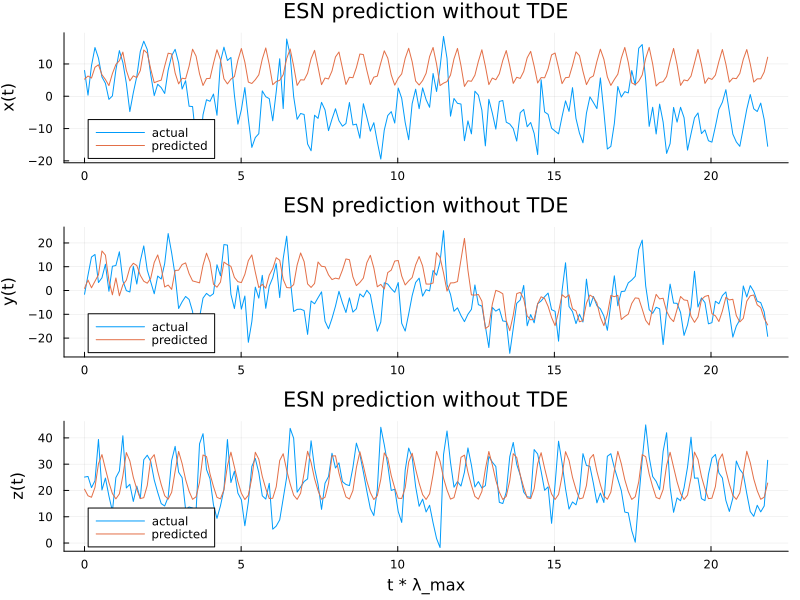

In [33]:
plot_prediction_sep(esn_x_1D,esn_y_1D,esn_z_1D, W_out_x_1D,  W_out_y_1D, W_out_z_1D,test_data_x_1D,test_data_y_1D,test_data_z_1D, l_max, "ESN prediction without TDE")

[27.39616306286973, 40.81566073565806, 20.951992681251205, 22.3476575705106, 15.824712639976914, 21.659841977215265, 16.893829369059592, 31.695806069248317, 33.40756023313535, 31.036111058292448, 23.98508944366887, 19.26233590653373, 15.00133921102429, 14.102815353123631, 17.46023465102484, 31.403315764222533, 36.778981483096814, 26.945145865729653, 24.84937095595965, 12.711164973461738, 13.721364540654463, 13.30392969774839, 12.050786650580559, 37.76608509048077, 41.599922249054096, 27.98762494737832, 24.466205982989592, 14.47816360221442, 9.379221082414231, 14.165695982353032, 20.37471405620279, 39.364192772360525, 23.006826371043907, 27.320927487249428, 18.97899489461271, 16.462696516989148, 6.58637405974363, 15.644223935829553, 29.143142414588308, 32.173667809486794, 26.735829277197595, 17.97669268473751, 16.72336205310059, 22.711643442525432, 5.266306729359305, 6.4493150827249, 8.81898920616103, 16.929103415526207, 25.051068027241065, 43.63303628052578, 39.86566764941098, 19.34630

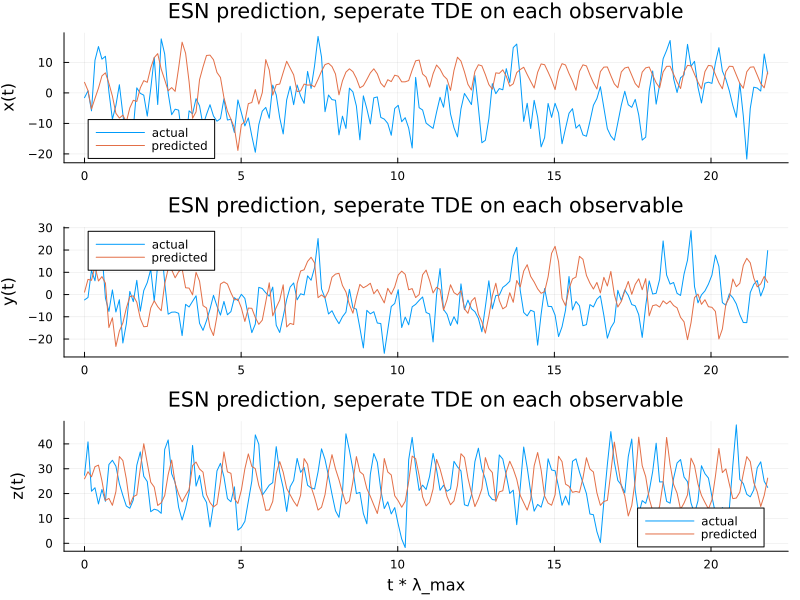

In [34]:
plot_prediction_sep(esn_x_emb, esn_y_emb,esn_z_emb, W_out_x_emb,W_out_y_emb, W_out_z_emb, test_x_data_emb,test_y_data_emb,test_z_data_emb, l_max, "ESN prediction, seperate TDE on each observable")

## Plot error curves

In [35]:
# compute predictions
steps_to_predict = size(test_data_x_1D, 2)
prediction_x = esn_x_1D(Generative(steps_to_predict), W_out_x_1D)[1,:]
prediction_y = esn_y_1D(Generative(steps_to_predict), W_out_y_1D)[1,:]
prediction_z = esn_z_1D(Generative(steps_to_predict), W_out_z_1D)[1,:]

prediction_x_emb = esn_x_emb(Generative(steps_to_predict), W_out_x_emb)[1,:]
prediction_y_emb = esn_y_emb(Generative(steps_to_predict), W_out_y_emb)[1,:]
prediction_z_emb = esn_z_emb(Generative(steps_to_predict), W_out_z_emb)[1,:];

In [36]:
times = Δt*collect(0:steps_to_predict)[1:end-1] / l_max;

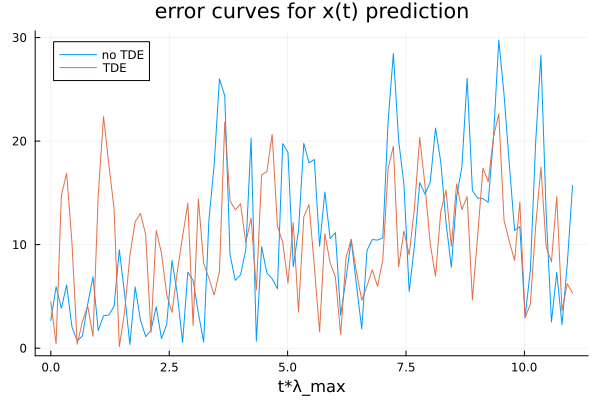

In [37]:
plot(times[1:100], abs.(prediction_x-test_data_x_1D[1,:])[1:100],label = "no TDE", title="error curves for x(t) prediction")
plot!(times[1:100],abs.(prediction_x_emb-test_data_x_1D[1,:])[1:100], label ="TDE", xlabel="t*λ_max")

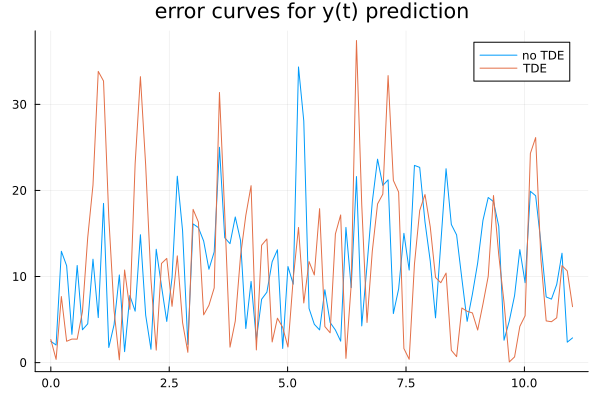

In [38]:
plot(times[1:100], abs.(prediction_y-test_data_y_1D[1,:])[1:100],label = "no TDE", title="error curves for y(t) prediction")
plot!(times[1:100], abs.(prediction_y_emb-test_data_y_1D[1,:])[1:100], label ="TDE")

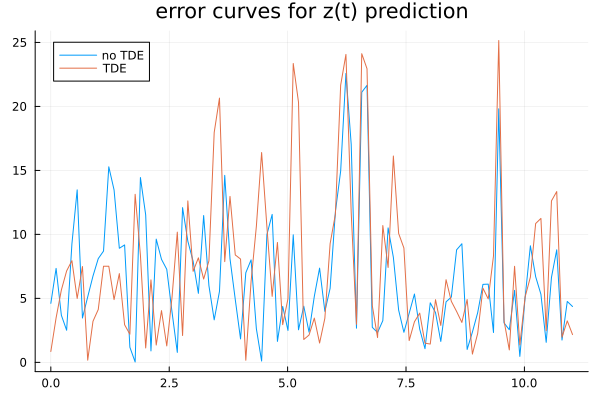

In [39]:
plot(times[1:100],abs.(prediction_z-test_data_z_1D[1,:])[1:100],label = "no TDE", title="error curves for z(t) prediction")
plot!(times[1:100],abs.(prediction_z_emb-test_data_z_1D[1,:])[1:100], label ="TDE")